# Imports and Installs

In [124]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# measure time for ML HyperParams search
import time
from datetime import date

# ML models and utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# 0) One DataFrame with Dummies
* including newly defined "month-week_of_month"

## 0.1) Read and truncate data (last 25 years from 2000), define variable sets


In [125]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("./stocks_df_combined_2024_05_07.parquet.brotli", )

In [126]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221142 entries, 0 to 5426
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.5+ MB


In [127]:
# growth indicators (but not future growth)
# g.find() 1 if True, -1 if False
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]


In [128]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

In [129]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [130]:
df_full.growth_future_5d.describe()

count    220977.000000
mean          1.004630
std           0.051592
min           0.412383
25%           0.979594
50%           1.003802
75%           1.028273
max           3.018887
Name: growth_future_5d, dtype: float64

In [131]:
# 54% of data records have positive future growth>0
df_full.is_positive_growth_5d_future.mean()

0.5411319423718697

In [132]:
# moving to strong growth (54% -> ~ 32%)
df_full.growth_future_5d.quantile(0.68)

1.0202201074172228

In [133]:
# TODO HA4 Q3: Define a new variable 'is_strong_positive_growth_5d_future' 
#   according to the task
#  it will be automatically added the the list TO_PREDICT

#Question 3 (2 points): Predicting Strong Future Growth


The idea: There are many "neutral" growth days (with very small positive or negative growth), which may be extremely hard to predict. Let's aim to predict strong positive growth and potentially remove some headache for the models.

Define a new column for the strong growth. Define a new field is_strong_positive_growth_5d_future in the original dataset df_full. It should equal to 1 only if the future growth is higher than 2% (growth_future_5d is higher than 1.02)

Generate correct true value datasets. Change the value of a variable to_predict to the new feature is_strong_positive_growth_5d_future. Ensure that all vectors with true values (y_train, y_valid, y_test, y_all, y_train_valid) are based on the new feature to predict.
Run the workbook till the end. Find the best CAGR for the model-based predictions. You should see that the best performing simulation (for model-based predictions) should be for the prediction pred6_clf_best, although it should be lower than the one in the Workbook (1.1311).

Write down the new CAGR as a result.

In [134]:
# Define the new column 'is_strong_positive_growth_5d_future'
df_full['is_strong_positive_growth_5d_future'] = (df_full['growth_future_5d'] > 1.02).astype(int)

In [135]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]


In [136]:
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV


In [137]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

/var/folders/n3/qnzrd2254zxfjlr0q6_j679m0000gn/T/ipykernel_95278/2841410488.py:2: RuntimeWarning:

divide by zero encountered in log



In [138]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

In [139]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [140]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [141]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [142]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [143]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER
# 所有的欄位由五類的欄位組成：OHLCV, CATEGORICAL, NUMERICAL, TO_DROP, TO_PREDICT

[]

In [144]:
df_full.Ticker.nunique()

33

In [145]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 204 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(129), int32(64), int64(6), object(2)
memory usage: 241.1+ MB


## 0.2) Dummies

In [146]:
# dummy variables can't be generated from Date and numeric variables ==> convert to STRING (to define groups for Dummies)
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

In [147]:
# 列舉所有可能的結果
df.loc[:,'Month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

In [148]:
df.loc[:,'Weekday'].unique()
# 這種表示方式通常是基於 Python 的 datetime 模塊中 weekday() 方法
# 的返回值，該方法將星期一作為一周的開始，並返回 0 到 6 的整數。

array(['0', '1', '2', '3', '4', '6', '5'], dtype=object)

### 0.2.1) Create a new string column 'month_wom' (month_week_of_month)

In [149]:
# define week of month
df.loc[:,'wom'] = df.Date.apply(lambda d: (d.day-1)//7 + 1)
# convert to string
df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)

In [150]:
df.loc[:,'wom'].unique()
# 代表某月的第幾週，等一下要串接成如'July_W1'用的

array(['1', '2', '3', '4', '5'], dtype=object)

In [151]:
# check values for week-of-month (should be between 1 and 5)
df.wom.value_counts()

wom
2    42817
3    42007
4    41715
1    41490
5    14646
Name: count, dtype: int64

In [152]:
df.loc[:,'month_wom'] = df.Month + '_w' + df.wom

In [153]:
# examples of encoding
df.month_wom.value_counts()[0:2]

month_wom
February_w1    3705
January_w2     3686
Name: count, dtype: int64

In [154]:
# del wom temp variable
del df['wom']

### 0.2.2) Generate all dummies

In [155]:
# what are the categorical features?
CATEGORICAL.append('month_wom')


In [156]:
df[CATEGORICAL]


,Month,Weekday,Ticker,ticker_type,month_wom
3490,January,0,MSFT,US,January_w1
3491,January,1,MSFT,US,January_w1
3492,January,2,MSFT,US,January_w1
3493,January,3,MSFT,US,January_w1
3494,January,4,MSFT,US,January_w1
...,...,...,...,...,...
5422,April,1,LT.NS,INDIA,April_w5
5423,May,3,LT.NS,INDIA,May_w1
5424,May,4,LT.NS,INDIA,May_w1
5425,May,0,LT.NS,INDIA,May_w1


In [157]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [158]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 115 entries, Month_April to month_wom_September_w5
dtypes: int32(115)
memory usage: 81.5 MB


In [159]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()

In [160]:
# Concatenate the dummy variables with the original DataFrame
# 橫向合併（axis=1）
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [161]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 299 entries, growth_1d to month_wom_September_w5
dtypes: float64(121), int32(177), int64(1)
memory usage: 294.8 MB


### 0.2.3 Define "DUMMIES_SHORT"

### 0.2.4) Temporal split

In [162]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.7).
        val_prop (float): Proportion of data for validation set (default: 0.15).
        test_prop (float): Proportion of data for test set (default: 0.15).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [163]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [164]:
# the split is approximate!
  # as tickers can have a different history
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.675834
test          0.163290
validation    0.160876
Name: count, dtype: float64

In [165]:
# remove the "segmentation" problem 
# (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [166]:
# EXACT DATES for the split:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
# 這個是把時間切分成三個區間：train, validation, test 作表
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,count,min,max
split,,,
test,29829,2020-09-14,2024-05-07
train,123458,2000-01-03,2017-01-16
validation,29388,2017-01-17,2020-09-11


In [167]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 321 entries, Open to split
dtypes: datetime64[ns](2), float64(129), int32(178), int64(6), object(6)
memory usage: 324.7+ MB


### 0.2.5 Define dataframes for Modeling (ML) and cleane them

In [168]:
# Features to be used in predictions (incl. new dummies)

# TODO HA4 Q2: use correct dummies here : DUMMIES_SHOR

features_list = NUMERICAL+DUMMIES

# What we're trying to predict?

# TODO HA4 Q3: use correct feature to predict 'is_strong_positive_growth_5d_future'

# to_predict = 'is_positive_growth_5d_future'
to_predict = 'is_strong_positive_growth_5d_future'

# 分成四個 df
train_df = new_df[new_df.split.isin(['train'])].copy(deep=True)
valid_df = new_df[new_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df =  new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]
X_train_valid = train_valid_df[features_list+[to_predict]]
X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)
from pprint import pprint
pprint(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')

('length: X_train (123458, 300),  X_validation (29388, 300), X_test (29829, '
 '300), X_train_valid = (152846, 300),  all combined: X_all (182675, 300)')


In [169]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0, inplace=True)
  return df

In [170]:
# Clean from +-inf and NaNs:

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
X_test = clean_dataframe_from_inf_and_nan(X_test)
X_all = clean_dataframe_from_inf_and_nan(X_all)

In [171]:
# parpare y_train, y_valid, y_train_valid, y_test, y_all for training and testing
# parpare X_train, X_valid, X_train_valid, X_test, X_all for training and testing
y_train = X_train[to_predict]

y_valid = X_valid[to_predict]

y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes

del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]

del X_test[to_predict]

del X_all[to_predict]

# 1) Modeling

## 1.1) Manual 'rule of thumb' predictions
* (pred0) CCI>200 (binary, on technical indicator CCI)
* (pred1) growth_1d>1
* (pred2) (growth_1d>1) & (growth_snp500_1d>1)
* (pred3) (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
* (pred4) (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)

In [172]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_1d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_1d'] > 1) & (new_df['growth_snp500_1d'] > 1)).astype(int)
new_df['pred3_manual_gdp_and_fastd'] = ((new_df['gdppot_us_yoy'] <= 0.027) & (new_df['fastd'] >=0.251)).astype(int)
new_df['pred4_manual_gdp_and_wti30d'] = ((new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)).astype(int)

In [173]:
# example output manual predictions:
new_df[['cci','growth_1d','growth_snp500_1d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_gdp_and_fastd','pred4_manual_gdp_and_wti30d', to_predict]]

,cci,growth_1d,growth_snp500_1d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_strong_positive_growth_5d_future
3490,26.847237,0.998394,0.990451,0,0,0,0,0,0
3491,-34.319663,0.966220,0.961655,0,0,0,0,0,0
3492,-97.318008,1.010544,1.001922,0,1,1,0,0,0
3493,-169.947507,0.966502,1.000956,0,0,0,0,0,0
3494,-142.142685,1.013068,1.027090,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
5422,-29.424989,0.988994,0.984269,0,0,0,1,0,0
5423,-26.657181,1.001447,1.009128,0,1,1,1,0,0
5424,-123.785473,0.972302,1.012557,0,0,0,1,0,0
5425,-181.986224,0.989571,1.010326,0,0,0,1,0,0


In [174]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
new_df[PREDICTIONS]

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d
3490,0,0,0,0,0
3491,0,0,0,0,0
3492,0,1,1,0,0
3493,0,0,0,0,0
3494,0,1,1,0,0
...,...,...,...,...,...
5422,0,0,0,1,0
5423,0,1,1,1,0
5424,0,0,0,1,0
5425,0,0,0,1,0


In [175]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [176]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
0    565
1    234
Name: count, dtype: int64
is_correct_pred0
0    0.707134
1    0.292866
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
0    10751
1     4850
Name: count, dtype: int64
is_correct_pred1
0    0.689122
1    0.310878
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
0    7248
1    3207
Name: count, dtype: int64
is_correct_pred2
0    0.693257
1    0.306743
Name: count, dtype: float64

In [177]:
# TODO HA4 Q1: run prediction correctness for 'is_positive_growth_5d_future' (should be lower)

In [178]:
to_predict

'is_strong_positive_growth_5d_future'

In [179]:
new_df[PREDICTIONS+IS_CORRECT+[to_predict]]

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_strong_positive_growth_5d_future
3490,0,0,0,0,0,1,1,1,1,1,0
3491,0,0,0,0,0,1,1,1,1,1,0
3492,0,1,1,0,0,1,0,0,1,1,0
3493,0,0,0,0,0,1,1,1,1,1,0
3494,0,1,1,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5422,0,0,0,1,0,1,1,1,0,1,0
5423,0,1,1,1,0,1,0,0,0,1,0
5424,0,0,0,1,0,1,1,1,0,1,0
5425,0,0,0,1,0,1,1,1,0,1,0


## 1.2) Decision Tree Classifier

### 1.2.1) Defining Functions to clean_df(), fit_decision_tree(), predict_decision_tree()
* here we discuss only the Decision Tree Classifier for binary predictions (and not the Regressor)

In [180]:
# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [181]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 12.8 s, sys: 121 ms, total: 12.9 s
Wall time: 13 s


In [182]:
# predict on a full dataset
y_pred_all = clf_10.predict(X_all)

In [183]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred5_clf_10'] = y_pred_all

In [184]:
to_predict

'is_strong_positive_growth_5d_future'

In [185]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict=to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
0    565
1    234
Name: count, dtype: int64
is_correct_pred0
0    0.707134
1    0.292866
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
0    10751
1     4850
Name: count, dtype: int64
is_correct_pred1
0    0.689122
1    0.310878
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
0    7248
1    3207
Name: count, dtype: int64
is_correct_pred2
0    0.693257
1    

In [186]:
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10']

In [187]:
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4',
 'is_correct_pred5']

## 1.2.3 Hyperparams tuning for a Decision Tree Classifier

In [188]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text

In [189]:
# pre-calculated results of Hyperparameter tuning: full dataset (300 features) and is_positive_growth_5d
precision_by_depth = {1: 0.5552, 2: 0.5553, 3: 0.5552, 4: 0.5552, 5: 0.5555, 6: 0.5712, 7: 0.5684, 8: 0.5684, 9: 0.57, 10: 0.5653, 11: 0.567, 12: 0.5719, 13: 0.5707, 14: 0.5845, 15: 0.5864, 16: 0.5721, 17: 0.5767, 18: 0.5682, 19: 0.5638, 20: 0.573}
best_depth = 15
best_precision = 0.5864

In [190]:
print(f'Best precision and depth = {best_depth}, precision (on test)={best_precision}')

Best precision and depth = 15, precision (on test)=0.5864


In [191]:
# TODO HA4 Q1: compare precision_by_depth with below? Any improvements? What's the optimal hyperparams?

In [192]:
# TODO HA4 Q2: compare precision_by_depth with below? Any improvements? What's the optimal hyperparams?

In [193]:
list(precision_by_depth.items())

[(1, 0.5552),
 (2, 0.5553),
 (3, 0.5552),
 (4, 0.5552),
 (5, 0.5555),
 (6, 0.5712),
 (7, 0.5684),
 (8, 0.5684),
 (9, 0.57),
 (10, 0.5653),
 (11, 0.567),
 (12, 0.5719),
 (13, 0.5707),
 (14, 0.5845),
 (15, 0.5864),
 (16, 0.5721),
 (17, 0.5767),
 (18, 0.5682),
 (19, 0.5638),
 (20, 0.573)]

In [194]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[54, 60],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()

In [195]:
%%time
clf_best,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 17.9 s, sys: 93 ms, total: 18 s
Wall time: 18 s


In [196]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree


n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 7551
Number of leaves: 3776


In [197]:
clf_best

DecisionTreeClassifier(max_depth=15, random_state=42)

In [198]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)

In [199]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_best'] = y_pred_clf_best

In [200]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict=to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
0    565
1    234
Name: count, dtype: int64
is_correct_pred0
0    0.707134
1    0.292866
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
0    10751
1     4850
Name: count, dtype: int64
is_correct_pred1
0    0.689122
1    0.310878
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
0    7248
1    3207
Name: count, dtype: int6

In [201]:
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best']

In [202]:
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4',
 'is_correct_pred5',
 'is_correct_pred6']

## 1.3) Random Forest
https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

In [203]:
# pre-calculated best precision matrix (max_depth, n_estimators) for Random Forest for a full dataset (300 features) and is_positive_future_growth_5d
best_precision_matrix_random_forest = {(15, 50): 0.5664, (15, 100): 0.565, (15, 200): 0.5711, (15, 500): 0.5741, (16, 50): 0.5703, (16, 100): 0.5679, (16, 200): 0.5728, (16, 500): 0.5739, (17, 50): 0.569, (17, 100): 0.569, (17, 200): 0.5734, (17, 500): 0.5709, (18, 50): 0.5641, (18, 100): 0.5636, (18, 200): 0.5704, (18, 500): 0.5678, (19, 50): 0.5634, (19, 100): 0.5623, (19, 200): 0.5683, (19, 500): 0.568, (20, 50): 0.561, (20, 100): 0.5655, (20, 200): 0.5744, (20, 500): 0.5778}


In [204]:

# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[15, 20])

# Show the figure
fig.show()

In [205]:
df

,precision_score,max_depth,n_estimators
0,0.5664,15,50
1,0.5650,15,100
2,0.5711,15,200
3,0.5741,15,500
4,0.5703,16,50
5,0.5679,16,100
6,0.5728,16,200
7,0.5739,16,500
8,0.5690,17,50
9,0.5690,17,100


In [206]:
%%time

# Suboptimal Predictor with less (than optimal) Estimators (200) and lower Max_Depth (17)
# several minutes to compute (6 min)

rf_best = RandomForestClassifier(n_estimators = 200,
                                 max_depth = 17,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)

CPU times: user 3min 18s, sys: 677 ms, total: 3min 19s
Wall time: 17.8 s


## 1.4 Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

There can be many reasons when Logistic Regression does not converge: https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/

## 1.5) ADVANCED: Deep Neural Network (DNN) and hyperparams tuning
* Tutorial from Tensorflow.org
* TowardsDataScience Hyperparameter Optimization with Keras
* Machine Learning Mastery tutorial with Keras Deep Learning

# 2) Different Decision rules to improve precision (varying threshold)

best model1 (clf_best): Decision Tree (max_depth=15)
best model2 (rf_best): Random Forest (n_estimators=200, max_depth=17)

## 2.1. Predicting probabilities (predict_proba), getting the distribution for probabilities, and new decision rules

In [207]:
# y_pred_test = best_lr.predict_proba(X_test)

# predicting probability instead of a lable

y_pred_test = clf_best.predict_proba(X_test)
y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

In [208]:
# example prediction of probabilities
y_pred_test
# clf_best.predict_proba(X_test) 的輸出是一個陣列，其中每個元素是一個 tuple，包含兩個數值。這些數值代表模型預測每個樣本屬於各個類別的概率。

array([[0.5745614 , 0.4254386 ],
       [0.5745614 , 0.4254386 ],
       [0.5745614 , 0.4254386 ],
       ...,
       [1.        , 0.        ],
       [0.79766537, 0.20233463],
       [0.79766537, 0.20233463]])

In [209]:
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])
y_pred_test_class1_df.head()

,Class1_probability
0,0.425439
1,0.425439
2,0.425439
3,0.000000
4,0.020408


In [210]:
# Mean prediction is 0.52, median is 0.58, 75% quantile is 0.75
y_pred_test_class1_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Class1_probability,29829.0,0.324742,0.311913,0.0,0.108856,0.224335,0.40137,1.0


In [211]:
# Unconditional probability of a positive growth is 55.5%
y_test.sum()/y_test.count()

0.31781152569646987

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



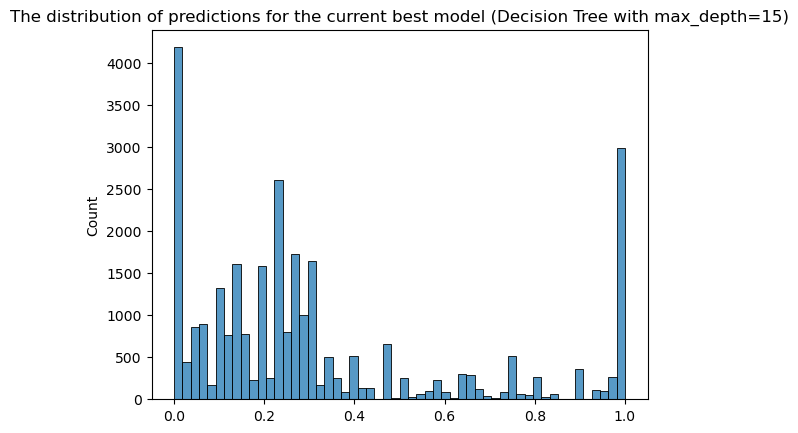

In [212]:
sns.histplot(y_pred_test_class1)

# Add a title
plt.title('The distribution of predictions for the current best model (Decision Tree with max_depth=15)')

# Show the plot
plt.show()

In [213]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [214]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [215]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,9480,20349,0,0,0.317812,1.000000,0.317812,0.482332,1.000000,1.000000
1,0.02,8094,17530,1386,2819,0.315876,0.853797,0.365852,0.461144,0.853797,0.861467
2,0.04,7896,17143,1584,3206,0.315348,0.832911,0.372188,0.457487,0.832911,0.842449
3,0.06,7654,16664,1826,3685,0.314746,0.807384,0.380133,0.452926,0.807384,0.818910
4,0.08,7349,16078,2131,4271,0.313698,0.775211,0.389554,0.446653,0.775211,0.790113
5,0.10,7271,15849,2209,4500,0.314490,0.766983,0.394616,0.446074,0.766983,0.778859
6,0.12,6828,14865,2652,5484,0.314756,0.720253,0.412753,0.438071,0.720253,0.730503
7,0.14,6391,13889,3089,6460,0.315138,0.674156,0.430822,0.429503,0.674156,0.682540
8,0.16,6009,12786,3471,7563,0.319713,0.633861,0.454993,0.425040,0.633861,0.628336
9,0.18,5959,12631,3521,7718,0.320549,0.628586,0.458514,0.424581,0.628586,0.620718


In [216]:
df_scores[(df_scores.threshold>=0.5) & (df_scores.threshold<=0.8)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
25,0.50,2146,4306,7334,16043,0.332610,0.226371,0.609776,0.269395,0.226371,0.211607
26,0.52,2064,4134,7416,16215,0.333011,0.217722,0.612793,0.263299,0.217722,0.203155
27,0.54,2060,4110,7420,16239,0.333874,0.217300,0.613463,0.263259,0.217300,0.201976
28,0.56,2042,4059,7438,16290,0.334699,0.215401,0.614570,0.262114,0.215401,0.199469
29,0.58,1959,3833,7521,16516,0.338225,0.206646,0.619364,0.256548,0.206646,0.188363
30,0.60,1958,3826,7522,16523,0.338520,0.206540,0.619565,0.256551,0.206540,0.188019
31,0.62,1932,3758,7548,16591,0.339543,0.203797,0.620973,0.254713,0.203797,0.184677
32,0.64,1916,3750,7564,16599,0.338157,0.202110,0.620705,0.253004,0.202110,0.184284
33,0.66,1701,3401,7779,16948,0.333399,0.179430,0.625197,0.233301,0.179430,0.167134
34,0.68,1669,3323,7811,17026,0.334335,0.176055,0.626739,0.230652,0.176055,0.163300


<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)'}, xlabel='threshold'>

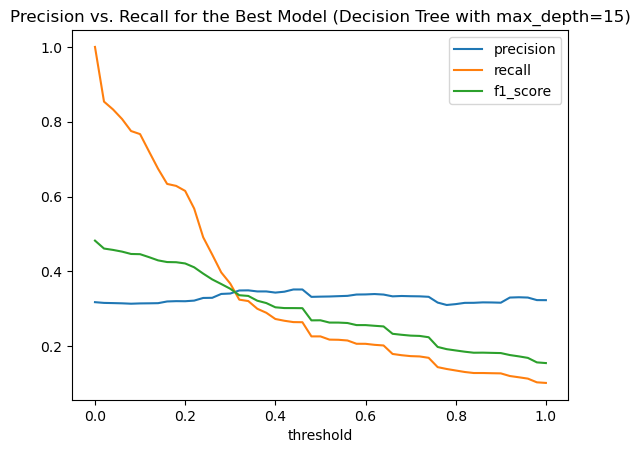

In [217]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)')

## 2.2) [Code Snippet 6] Defining new columns with Predictions in new_df: pred7..pred10
* pred7 and pred8 are 2 decision rules for the Decision Tree (best model with max_depth=15)
* pred9 and pred10 are 2 decision rules for the Random Forest (second best model)

In [218]:
# adding Decision Tree predictors (clf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78


y_pred_all = clf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred7'] = y_pred_all_class1_array
new_df['pred7_clf_best_rule_66'] = (y_pred_all_class1_array >= 0.66).astype(int)

new_df['proba_pred8'] = y_pred_all_class1_array
new_df['pred8_clf_best_rule_78'] = (y_pred_all_class1_array >= 0.78).astype(int)

In [219]:
# adding Random Forest predictors (rf_best)
rf_best

RandomForestClassifier(max_depth=17, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [220]:
# adding Random Forest predictors (rf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred9'] = y_pred_all_class1_array
new_df['pred9_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred10'] = y_pred_all_class1_array
new_df['pred10_rf_best_rule_60'] = (y_pred_all_class1_array >= 0.6).astype(int)

# TODO HA4 Q1: define new predictor for thresholds 0.51..0.54, 0.56..0.59

In [221]:
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best']

<Axes: >

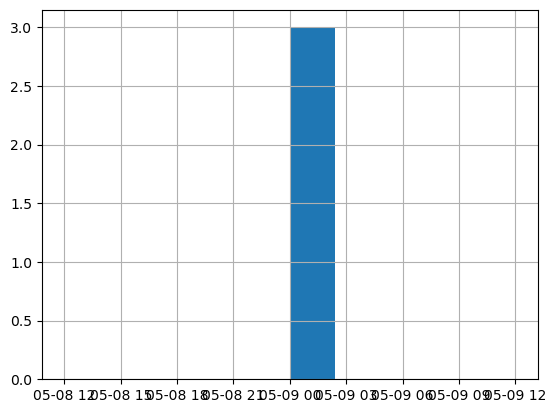

In [222]:
# When did it predict to trade for the "rare" prediction pred10? (only 2%)
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].Date.hist()

In [223]:

[g for g in new_df.keys() if (g.startswith('pred'))]

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best',
 'pred7_clf_best_rule_66',
 'pred8_clf_best_rule_78',
 'pred9_rf_best_rule_55',
 'pred10_rf_best_rule_60']

In [224]:
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].sort_values(by='Date')

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,pred6_clf_best,is_correct_pred6,proba_pred7,pred7_clf_best_rule_66,proba_pred8,pred8_clf_best_rule_78,proba_pred9,pred9_rf_best_rule_55,proba_pred10,pred10_rf_best_rule_60
5862,180.339996,182.550003,168.270004,169.500000,169.287430,64445500.0,NVDA,2022,May,0,...,1,0,0.968421,1,0.968421,1,0.622515,1,0.622515,1
6287,111.312500,114.000000,107.957001,108.789001,108.789001,128124000.0,AMZN,2022,May,0,...,0,1,0.000000,0,0.000000,0,0.615777,1,0.615777,1
6836,530.210022,535.799988,510.359985,512.659973,502.959656,1714700.0,ASML,2022,May,0,...,1,1,0.968421,1,0.968421,1,0.624951,1,0.624951,1


In [225]:
# Pred 10: How many positive prediction per day (out of 33 stocks possible)
pred10_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].groupby('Date')['pred10_rf_best_rule_60'].count())

In [226]:
pred10_daily_positive_count

,pred10_rf_best_rule_60
Date,
2022-05-09,3


In [227]:
# Pred 9: How many positive prediction per day (out of 33 stocks possible)
pred9_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred9_rf_best_rule_55==1)].groupby('Date')['pred9_rf_best_rule_55'].count())

In [228]:
# Unique trading days on Test (4 years)
new_df[(new_df.split=='test')].Date.nunique()

947

In [229]:
pred10_daily_positive_count

,pred10_rf_best_rule_60
Date,
2022-05-09,3


array([[<Axes: title={'center': 'pred10_rf_best_rule_60'}>]], dtype=object)

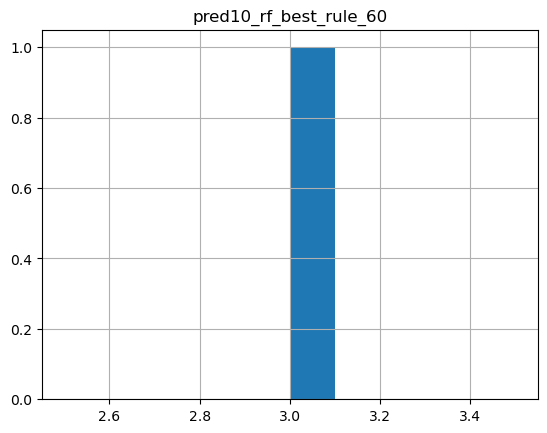

In [230]:
pred10_daily_positive_count.hist()

In [231]:
# 75% cases we have not more than 6 bets of $100
pred10_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred10_rf_best_rule_60,1.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0


array([[<Axes: title={'center': 'pred9_rf_best_rule_55'}>]], dtype=object)

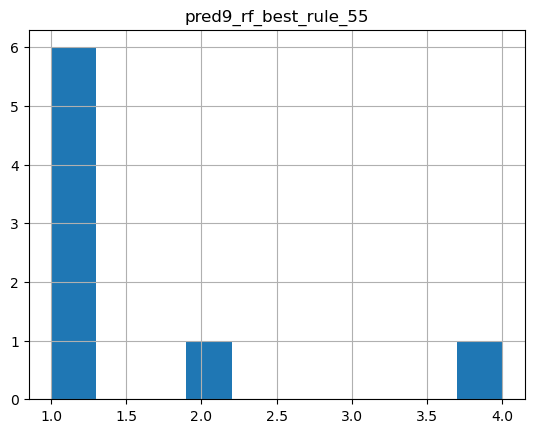

In [232]:
pred9_daily_positive_count.hist()

In [233]:
pred9_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred9_rf_best_rule_55,8.0,1.5,1.069045,1.0,1.0,1.0,1.25,4.0


## 2.3) Agg. stats on ALL predictions

In [234]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict=to_predict)


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best', 'pred7_clf_best_rule_66', 'pred8_clf_best_rule_78', 'pred9_rf_best_rule_55', 'pred10_rf_best_rule_60']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
0    565
1    234
Name: count, dtype: int64
is_correct_pred0
0    0.707134
1    0.292866
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
0    10751
1     4850
Name: count, dtype: int64
is_correct_pred1
0    0.689122
1    0.310878


In [235]:
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best',
 'pred7_clf_best_rule_66',
 'pred8_clf_best_rule_78',
 'pred9_rf_best_rule_55',
 'pred10_rf_best_rule_60']

In [236]:
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4',
 'is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred7',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10']

In [237]:
# Extract number from the prediction column

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))


10
10


In [238]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]


In [239]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]


In [240]:
# 作表用
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                 test          train    validation
pred5_clf_10           count  29829.000000  123458.000000  29388.000000
                       sum     3226.000000   11544.000000   1685.000000
                       mean       0.108150       0.093505      0.057336
pred6_clf_best         count  29829.000000  123458.000000  29388.000000
                       sum     6229.000000   23086.000000   4072.000000
                       mean       0.208824       0.186995      0.138560
pred7_clf_best_rule_66 count  29829.000000  123458.000000  29388.000000
                       sum     5102.000000   18762.000000   3337.000000
                       mean       0.171042       0.151971      0.113550
pred8_clf_best_rule_78 count  29829.000000  123458.000000  29388.000000
                       sum     4254.000000   14825.000000   2913.000000
                       mean       0.142613       0.120081      0.099122
pred9_rf_best_rule_55  count  29829.000000  123458.000000  29388.000000
                       sum       12.000000   16719.000000   2673.000000
                       mean       0.000402       0.135423      0.090955
pred10_rf_best_rule_60 count  29829.000000  123458.000000  29388.000000
                       sum        3.000000   11985.000000   1896.000000
                       mean       0.000101       0.097078      0.064516

In [241]:
# 10 predictions stats (check TEST set)
new_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T

split                                       test          train    validation
pred0_manual_cci             count  29829.000000  123458.000000  29388.000000
                             sum      799.000000    3162.000000    875.000000
                             mean       0.026786       0.025612      0.029774
pred1_manual_prev_g1         count  29829.000000  123458.000000  29388.000000
                             sum    15601.000000   62117.000000  15585.000000
                             mean       0.523015       0.503143      0.530318
pred2_manual_prev_g1_and_snp count  29829.000000  123458.000000  29388.000000
                             sum    10455.000000   41609.000000  10902.000000
                             mean       0.350498       0.337030      0.370968
pred3_manual_gdp_and_fastd   count  29829.000000  123458.000000  29388.000000
                             sum    29822.000000  107032.000000  29388.000000
                             mean       0.999765       0.866951      1.000000
pred4_manual_gdp_and_wti30d  count  29829.000000  123458.000000  29388.000000
                             sum        0.000000    5673.000000      0.000000
                             mean       0.000000       0.045951      0.000000
pred5_clf_10                 count  29829.000000  123458.000000  29388.000000
                             sum     3226.000000   11544.000000   1685.000000
                             mean       0.108150       0.093505      0.057336
pred6_clf_best               count  29829.000000  123458.000000  29388.000000
                             sum     6229.000000   23086.000000   4072.000000
                             mean       0.208824       0.186995      0.138560
pred7_clf_best_rule_66       count  29829.000000  123458.000000  29388.000000
                             sum     5102.000000   18762.000000   3337.000000
                             mean       0.171042       0.151971      0.113550
pred8_clf_best_rule_78       count  29829.000000  123458.000000  29388.000000
                             sum     4254.000000   14825.000000   2913.000000
                             mean       0.142613       0.120081      0.099122
pred9_rf_best_rule_55        count  29829.000000  123458.000000  29388.000000
                             sum       12.000000   16719.000000   2673.000000
                             mean       0.000402       0.135423      0.090955
pred10_rf_best_rule_60       count  29829.000000  123458.000000  29388.000000
                             sum        3.000000   11985.000000   1896.000000
                             mean       0.000101       0.097078      0.064516

# 3) Trading Simulations

* create simulation 1 features: like "sim1_pred0" ... "sim1_predLast"

## 3.1) Investing $100 on every positive prediction
* fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

### 3.1.2 Calculate fin. results for all fields
* Simplified and approximate calculation

In [242]:

def calculate_simulation_results(df):
    # Identify columns that start with 'pred' to determine which are prediction columns
    predictions = [col for col in df.columns if col.startswith('pred')]

    # Initialize a list to store the results of the simulations
    sim1_results = []

    # Loop through each prediction column to calculate financial results
    for pred in predictions:
        print(f'Calculating simulation for prediction {pred}:')
        # Extract the prefix from the prediction column name (e.g., 'pred1' from 'pred1_manual_cci')
        pred_prefix = pred.split('_')[0]

        # Calculate the gross revenue for each prediction
        df['sim1_gross_rev_' + pred_prefix] = df[pred] * 100 * (df['growth_future_5d'] - 1)
        # Calculate the fees for each transaction, assuming a 0.2% fee rate
        df['sim1_fees_' + pred_prefix] = -df[pred] * 100 * 0.002
        # Calculate the net revenue by adding fees to the gross revenue
        df['sim1_net_rev_' + pred_prefix] = df['sim1_gross_rev_' + pred_prefix] + df['sim1_fees_' + pred_prefix]

        # Filter the dataframe for test set records where the prediction is 1 (true)
        filter_test_and_positive_pred = (df.split == 'test') & (df[pred] == 1)
        # Count the number of investments made based on the prediction
        sim1_count_investments = len(df[filter_test_and_positive_pred])
        # Sum the gross revenue for the filtered predictions
        sim1_gross_rev = df[filter_test_and_positive_pred]['sim1_gross_rev_' + pred_prefix].sum()
        # Sum the fees for the filtered predictions
        sim1_fees = df[filter_test_and_positive_pred]['sim1_fees_' + pred_prefix].sum()
        # Sum the net revenue for the filtered predictions
        sim1_net_rev = df[filter_test_and_positive_pred]['sim1_net_rev_' + pred_prefix].sum()

        # Calculate the percentage of fees relative to the gross revenue
        sim1_fees_percentage = -sim1_fees / sim1_gross_rev if sim1_gross_rev > 0 else None
        # Calculate the average net revenue per investment
        sim1_average_net_revenue = sim1_net_rev / sim1_count_investments if sim1_count_investments > 0 else None

        # Calculate the average number of investments per day
        df_investments_count_daily = pd.DataFrame(df[filter_test_and_positive_pred].groupby('Date')[pred].count())
        sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
        # Calculate the 75th percentile of daily investments
        sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)
        # Estimate the capital required based on the 75th percentile of daily investments
        sim1_capital = 100 * 5 * sim1_q75_investments_per_day
        # Calculate the Compound Annual Growth Rate (CAGR) over 4 years
        sim1_CAGR = ((sim1_capital + sim1_net_rev) / sim1_capital) ** (1 / 4) if sim1_capital != 0 else None

        # Append the results for this prediction to the results list
        sim1_results.append((pred, sim1_count_investments, sim1_gross_rev, sim1_fees, sim1_net_rev, sim1_fees_percentage, sim1_average_net_revenue, sim1_avg_investments_per_day, sim1_capital, sim1_CAGR))

    # Create a DataFrame from the simulation results
    columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage', 'sim1_average_net_revenue', 'sim1_avg_investments_per_day', 'sim1_capital', 'sim1_CAGR']
    df_sim1_results = pd.DataFrame(sim1_results, columns=columns_simulation)


    return df, df_sim1_results

# Example usage:
# df, df_sim1_results = calculate_simulation_results(dataframe)

In [243]:
df, df_sim1_results = calculate_simulation_results(new_df)

Calculating simulation for prediction pred0_manual_cci:
Calculating simulation for prediction pred1_manual_prev_g1:
Calculating simulation for prediction pred2_manual_prev_g1_and_snp:
Calculating simulation for prediction pred3_manual_gdp_and_fastd:
Calculating simulation for prediction pred4_manual_gdp_and_wti30d:
Calculating simulation for prediction pred5_clf_10:
Calculating simulation for prediction pred6_clf_best:
Calculating simulation for prediction pred7_clf_best_rule_66:
Calculating simulation for prediction pred8_clf_best_rule_78:
Calculating simulation for prediction pred9_rf_best_rule_55:
Calculating simulation for prediction pred10_rf_best_rule_60:


In [244]:
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR
0,pred0_manual_cci,799,309.045890,-159.8,149.845890,0.517075,0.187542,1.866822,1000.0,1.035523
1,pred1_manual_prev_g1,15601,6913.217124,-3120.2,3812.817124,0.451338,0.244396,16.526483,11000.0,1.077237
2,pred2_manual_prev_g1_and_snp,10455,4213.424501,-2091.0,2139.624501,0.496271,0.204651,21.918239,13000.0,1.038826
3,pred3_manual_gdp_and_fastd,29822,14893.285316,-5964.4,8961.885316,0.400476,0.300513,31.491024,16500.0,1.114555
4,pred4_manual_gdp_and_wti30d,0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
5,pred5_clf_10,3226,1059.242032,-645.2,415.442032,0.609115,0.128779,5.332231,3000.0,1.032955
6,pred6_clf_best,6229,3523.912904,-1245.8,2281.912904,0.353527,0.366337,7.078409,4625.0,1.105460
7,pred7_clf_best_rule_66,5102,2605.649634,-1020.4,1589.049634,0.391611,0.311456,6.306551,4000.0,1.087225
8,pred8_clf_best_rule_78,4254,1272.805444,-850.8,425.605444,0.668445,0.100048,5.439898,3500.0,1.029105
9,pred9_rf_best_rule_55,12,73.446530,-2.4,71.046530,0.032677,5.920544,1.500000,625.0,1.027282


In [245]:
# Correctly extract the numeric part from the 'prediction' string and convert it to integer
df_sim1_results['prediction_number'] = df_sim1_results['prediction'].str.extract('(\d+)').astype(int)

# Filter to keep only rows where the number is larger than a specific value, e.g., 5
filtered_df = df_sim1_results[df_sim1_results['prediction_number'] >= 5]


# Q3 Answer

In [246]:
# traverse the df_sim1_results to find the best CAGR, and find the best prediction is
best_cagr = filtered_df['sim1_CAGR'].max()
rounded_cagr = round(best_cagr, 4)
best_threshold = filtered_df.loc[filtered_df['sim1_CAGR'].idxmax(), 'prediction']
print(f'Q3(Predicting Strong Future Growth):The best CAGR is: {rounded_cagr}, and the best threshold rule is: {best_threshold}')

Q3(Predicting Strong Future Growth):The best CAGR is: 1.1055, and the best threshold rule is: pred6_clf_best
